Epoch: 10 | Re.Loss: 84.6779938, KL.Loss: 3.0551188 | Lr: 0.0000024 Temp: 0.1900000: 100%|██████████| 9380/9380 [01:51<00:00, 83.97it/s]  


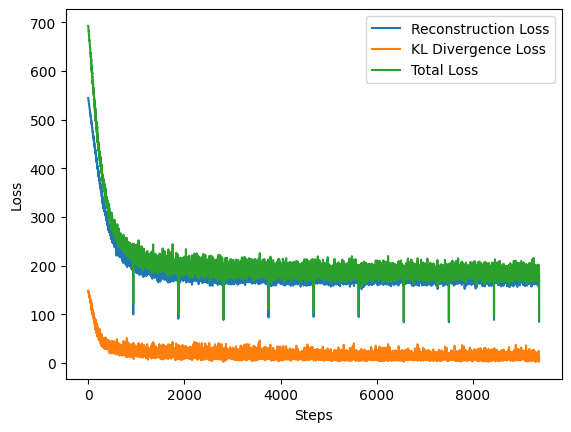

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from prodigyopt import Prodigy

# 定义模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, categorical_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, categorical_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

class Decoder(nn.Module):
    def __init__(self, categorical_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(categorical_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # 确保输出在[0,1]范围内
        return x

# def gumbel_softmax(logits, temperature):
#     gumbels = -torch.empty_like(logits).exponential_().log()
#     y = logits + gumbels
#     return torch.nn.functional.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    gs = F.gumbel_softmax(logits, tau=temperature, hard=True, eps=1e-10, dim=-1)
    return gs


# 超参数
input_dim = 784
hidden_dim = 256
categorical_dim = 10
output_dim = input_dim
temperature = 1.0
batch_size = 64
epochs = 10
dataset_name = "MNIST"

initial_lr = 1e-4
initial_temperature = 1.0
final_temperature = 0.1
annealing_rate = (initial_temperature - final_temperature) / epochs

# 加载数据
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
if dataset_name == "MNIST":
    dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
elif dataset_name == "FashionMNIST":
    dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 创建模型
encoder = Encoder(input_dim, hidden_dim, categorical_dim)
decoder = Decoder(categorical_dim, hidden_dim, output_dim)

# 优化器
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
# 学习率调度器
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)  # T_max设置为周期长度


# 用于记录损失的列表
recon_losses = []
kl_losses = []
total_losses = []
lr_list = []
temperature_list = []

# 创建一个tqdm进度条
progress_bar = tqdm(total=(len(dataloader) * epochs), desc="Training Progress")

# 训练过程
for epoch in range(epochs):
    for batch in dataloader:
        x, labels_in_batch = batch
        x = x.view(-1, input_dim)  # 确保x的形状
        logits = encoder(x)
        z = gumbel_softmax(logits, temperature)
        x_recon = decoder(z)

        # print("x_recon min:", x_recon.min().item(), "max:", x_recon.max().item())
        # print("x min:", x.min().item(), "max:", x.max().item())
        # if x_recon.min().item() < 0 or x_recon.max().item() > 1 or x.min().item() < 0 or x.max().item() > 1:
        #     print("x_recon min:", x_recon.min().item(), "max:", x_recon.max().item())
        #     print("x min:", x.min().item(), "max:", x.max().item())
        #     exit()
   
        # 损失函数
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / batch_size
        log_softmax_logits = F.log_softmax(logits, dim=-1)
        uniform_distribution = torch.ones_like(log_softmax_logits) * (1.0 / categorical_dim)
        # 根据labels_in_batch创建one-hot向量
        one_hot_labels = torch.zeros_like(log_softmax_logits).scatter_(1, labels_in_batch.unsqueeze(1), 1.0)
        kl_loss = F.kl_div(log_softmax_logits, one_hot_labels, reduction='sum')
        loss = recon_loss + kl_loss

        # 梯度下降
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录损失
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())
        total_losses.append(loss.item())
        lr_list.append(scheduler.get_last_lr()[0])
        temperature_list.append(temperature)

        # 更新进度条
        # progress_bar.set_postfix({'Epoch': epoch+1, 'Reconstruction Loss': recon_loss.item(), 'KL Divergence Loss': kl_loss.item()}, refresh=True)
        progress_bar.set_description(f'Epoch: {epoch+1} | Re.Loss: {recon_loss.item():.7f}, KL.Loss: {kl_loss.item():.7f} | Lr: {scheduler.get_last_lr()[0]:.7f} Temp: {temperature:.7f}', refresh=True)
        progress_bar.update(1)

    scheduler.step()  # 更新学习率
    temperature -= annealing_rate # 更新温度
    temperature = max(temperature, final_temperature)  # 确保温度不低于最小值

progress_bar.close()

# 绘制损失曲线
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence Loss')
plt.plot(total_losses, label='Total Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


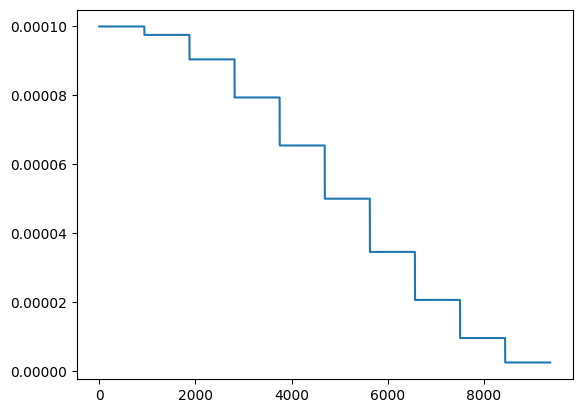

In [2]:
plt.plot(lr_list, label='lr')
plt.show()

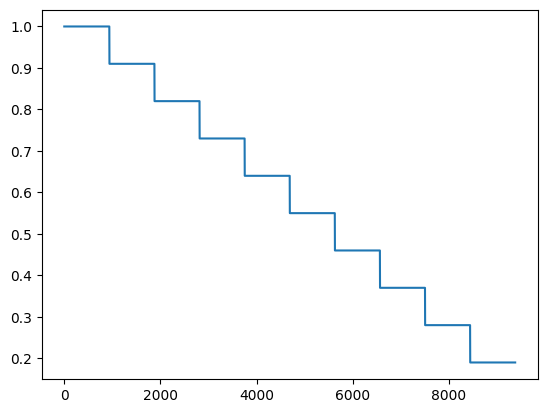

In [3]:
plt.plot(temperature_list, label='Temperature')
plt.show()

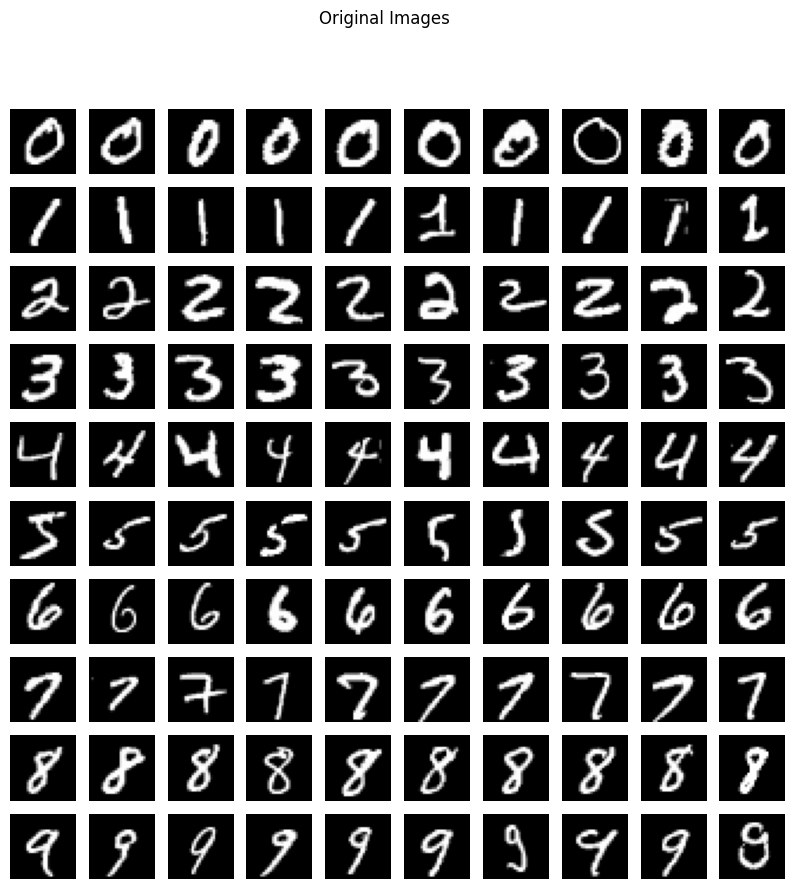

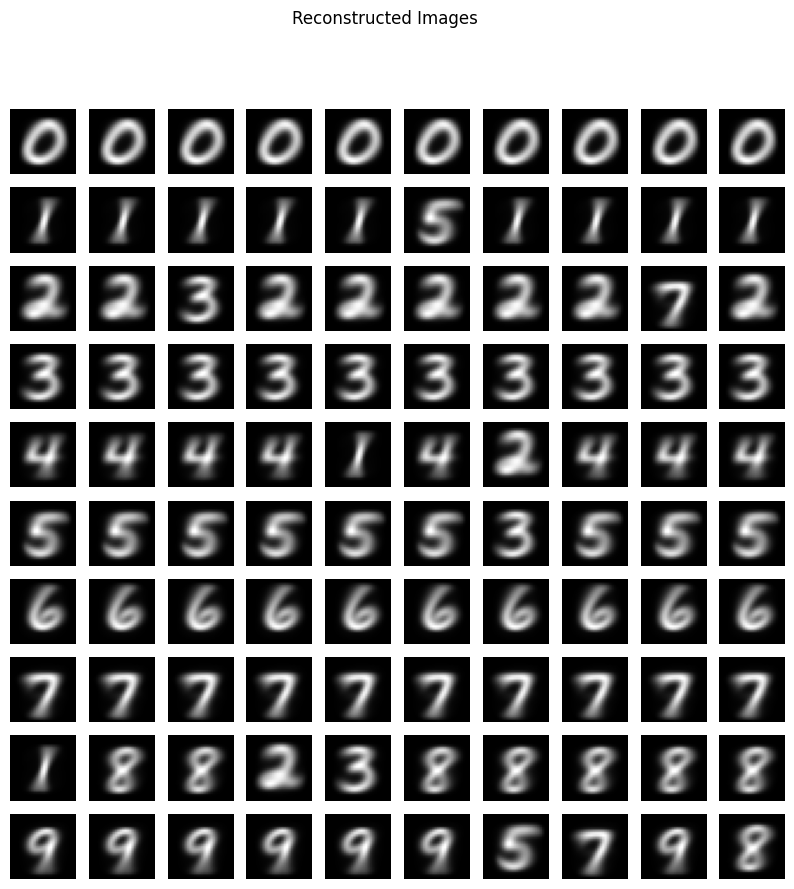

In [4]:
# 可视化
samples_per_class = 10
original_images = [[] for _ in range(10)]
reconstructed_images = [[] for _ in range(10)]

with torch.no_grad():
    for x, y in dataset:
        if all(len(images) >= samples_per_class for images in original_images):
            break
        x = x.view(-1, input_dim)
        logits = encoder(x)
        z = gumbel_softmax(logits, temperature)
        x_recon = decoder(z)
        original_images[y].append(x.view(28, 28).numpy())
        reconstructed_images[y].append(x_recon.view(28, 28).numpy())

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(samples_per_class):
        axes[i, j].imshow(original_images[i][j], cmap='gray')
        axes[i, j].axis('off')
plt.suptitle('Original Images')
plt.show()

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(samples_per_class):
        axes[i, j].imshow(reconstructed_images[i][j], cmap='gray')
        axes[i, j].axis('off')
plt.suptitle('Reconstructed Images')
plt.show()

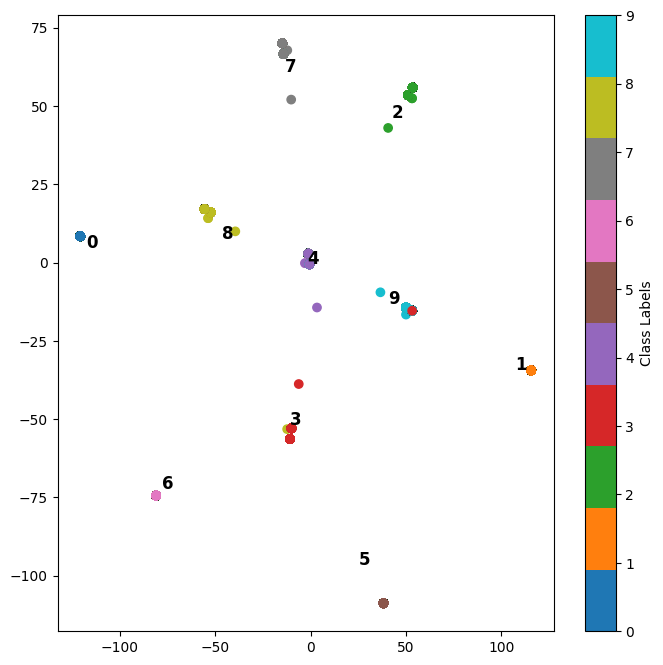

In [5]:
from sklearn.manifold import TSNE
import numpy as np

# 准备一个空的张量来存储所有类别的潜在向量
latent_vectors = torch.empty(0, categorical_dim).to(x.device)
labels = torch.empty(0, dtype=torch.long)

# 将整个数据集通过模型，并保存结果
with torch.no_grad():
    for x, y in dataloader:
        x = x.view(-1, input_dim)
        logits = encoder(x)
        z = gumbel_softmax(logits, temperature)
        latent_vectors = torch.cat([latent_vectors, z])
        labels = torch.cat([labels, y])

# 将潜在向量转换为numpy数组，以便使用t-SNE
latent_vectors = latent_vectors.cpu().numpy()
labels = labels.cpu().numpy()

# 使用t-SNE将潜在向量降维到2D
tsne = TSNE(n_components=2)
latent_vectors_2d = tsne.fit_transform(latent_vectors)

# 绘制结果
plt.figure(figsize=(8, 8))
scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Class Labels')
for i in range(10):
    centroid = np.mean(latent_vectors_2d[labels == i], axis=0)
    plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
plt.show()


In [6]:
# from sklearn.decomposition import PCA

# # 使用PCA将潜在向量降维到2D
# pca = PCA(n_components=2)
# latent_vectors_2d = pca.fit_transform(latent_vectors)

# # 绘制结果
# plt.figure(figsize=(10, 10))
# for i in range(10):
#     indices = labels == i
#     plt.scatter(latent_vectors_2d[indices, 0], latent_vectors_2d[indices, 1], label=str(i), alpha=0.5)
# plt.legend()
# plt.show()


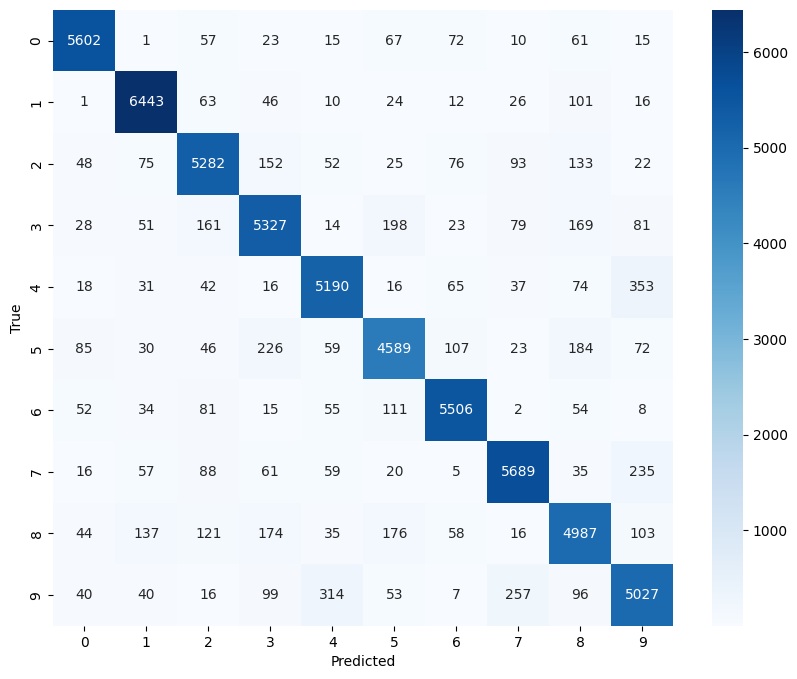

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 为每个潜在向量找到最可能的类别
predicted_labels = latent_vectors.argmax(axis=1)

# 计算混淆矩阵
cm = confusion_matrix(labels, predicted_labels)

# 使用Seaborn绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [9]:
# Rand-index
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(labels, predicted_labels)
print("Rand index: ", rand_index)

Rand index:  0.7833850537891622
